# 1. Data Generation

## 1.1. Ideal Simulation

In [ ]:
!pip install qiskit qiskit-aer pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=e7c921283b23200d9d43a81e6e9f21c95e05fe301571ed82a8d4f1d2c853bc15
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


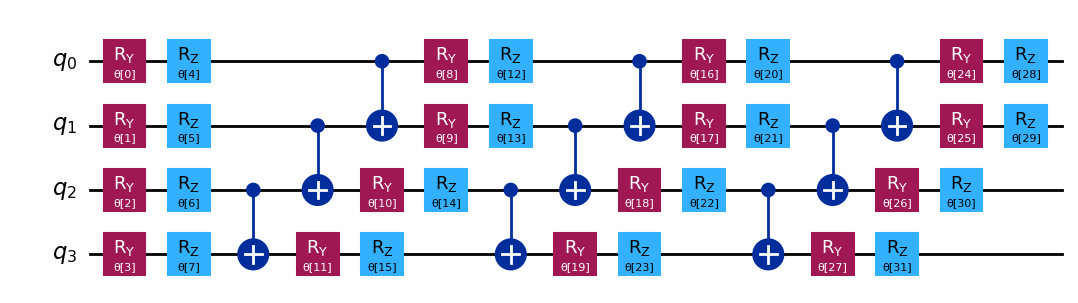

In [ ]:
from qiskit.circuit.library import efficient_su2

n_qubits = 4
circuit = efficient_su2(n_qubits)
circuit.draw("mpl")

In [ ]:
import qiskit
print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.2.3


## Requirements
## qiskit>=1.0.0
##qiskit-aer>=0.13.0
##numpy>=1.24.0
## scipy>=1.10.0
## !pip install qiskit>=1.0.0

##!pip install qiskit-aer>=0.13.0

In [ ]:
!pip install scipy>=1.10.0

In [ ]:
import numpy as np
import json
import os
from pathlib import Path
from itertools import product
import warnings
warnings.filterwarnings('ignore')

from qiskit import qasm2, QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, ReadoutError
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2


## Task 1- Generating the Dataset

# Data generation class
## All three stpes for data generation saved here

In [ ]:
class QEMDatasetGenerator:
    """Complete QEM dataset generator in a single clean class"""

    def __init__(self, num_qubits=4, seed=42):
        self.num_qubits = num_qubits
        self.seed = seed
        np.random.seed(seed)

    # ========================================================================
    # CIRCUIT GENERATION
    # ========================================================================

    def create_circuit(self, depth, entanglement):
        """
        Create EfficientSU2 circuit with random parameters

        Args:
            depth: Number of repetitions (1, 2, or 3)
            entanglement: Pattern ('linear', 'full', or 'pairwise')

        Returns:
            QuantumCircuit
        """
        # Create EfficientSU2 ansatz
        ansatz = EfficientSU2(
            num_qubits=self.num_qubits,
            reps=depth,
            entanglement=entanglement,
            insert_barriers=False
        )

        # Random parameters [0, 2π]
        params = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)

        # Bind parameters
        circuit = ansatz.assign_parameters(params)

        # Decompose to basic gates (CRITICAL: AerSimulator needs this!)
        circuit = circuit.decompose()

        return circuit

    def simulate_ideal(self, circuit):
        """Get ideal Z⊗Z⊗...⊗Z expectation value"""
        sv = Statevector.from_instruction(circuit)
        pauli_string = 'Z' * self.num_qubits
        observable = SparsePauliOp(pauli_string)
        return sv.expectation_value(observable).real

    # ========================================================================
    # NOISE MODELS
    # ========================================================================

    def create_noise_model(self, noise_type, error_rate):
        """Create noise model"""
        noise_model = NoiseModel()

        if noise_type == 'depolarizing':
            error_1q = depolarizing_error(error_rate, 1)
            error_2q = depolarizing_error(min(error_rate * 10, 0.3), 2)
            noise_model.add_all_qubit_quantum_error(error_1q, ['ry', 'rz'])
            noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

        elif noise_type == 'amplitude_damping':
            error = amplitude_damping_error(error_rate)
            noise_model.add_all_qubit_quantum_error(error, ['ry', 'rz'])

        elif noise_type == 'readout':
            readout_error = ReadoutError([
                [1 - error_rate, error_rate],
                [error_rate, 1 - error_rate]
            ])
            for qubit in range(self.num_qubits):
                noise_model.add_readout_error(readout_error, [qubit])

        return noise_model

    def simulate_noisy(self, circuit, noise_model):
        """Get noisy Z⊗Z⊗...⊗Z expectation value"""
        simulator = AerSimulator(noise_model=noise_model, method='density_matrix')

        qc = circuit.copy()
        qc.save_density_matrix()

        result = simulator.run(qc, shots=1).result()
        noisy_dm = result.data()['density_matrix']

        pauli_string = 'Z' * self.num_qubits
        observable = SparsePauliOp(pauli_string)

        return noisy_dm.expectation_value(observable).real

    # ========================================================================
    # MAIN GENERATION
    # ========================================================================

    def generate_dataset(self,
                        depth_multipliers=[1, 2, 3],
                        entanglements=['linear', 'full', 'pairwise'],
                        noise_types=['depolarizing', 'amplitude_damping', 'readout'],
                        error_rates=[0.001, 0.01, 0.1]):
        """
        Generate complete dataset with all combinations

        Returns:
            List of data samples
        """
        dataset = []

        # Generate all unique circuit configurations
        circuit_configs = list(product(depth_multipliers, entanglements))
        noise_configs = list(product(noise_types, error_rates))

        total = len(circuit_configs) * len(noise_configs)

        print(f"Generating {total} samples for {self.num_qubits} qubits...")

        count = 0
        for depth, entanglement in circuit_configs:
            # Create one circuit per unique configuration
            circuit = self.create_circuit(depth, entanglement)

            # Get ideal expectation
            x_ideal = float(self.simulate_ideal(circuit))

            # Apply all noise configurations to this circuit
            for noise_type, error_rate in noise_configs:
                # Create noise model
                noise_model = self.create_noise_model(noise_type, error_rate)

                # Get noisy expectation
                x_noisy = float(self.simulate_noisy(circuit, noise_model))

                # Create data sample
                sample = {
                    'num_qubits': self.num_qubits,
                    'depth': depth,
                    'entanglement': entanglement,
                    'noise_type': noise_type,
                    'error_rate': error_rate,
                    'x_noisy': x_noisy,
                    'x_ideal': x_ideal
                }

                dataset.append(sample)
                count += 1

        print(f"✓ Generated {count} samples")
        return dataset

## Dataset Saving in json

In [ ]:
def save_dataset(dataset, output_file):
    """Save dataset to JSON"""
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)

    with open(output_file, 'w') as f:
        json.dump(dataset, f, indent=2)

    print(f"✓ Saved to: {output_file}")

## CSV generation

In [ ]:
def save_csv(dataset, output_file):
    """Save dataset to CSV format"""
    import csv

    Path(output_file).parent.mkdir(parents=True, exist_ok=True)

    with open(output_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=dataset[0].keys())
        writer.writeheader()
        writer.writerows(dataset)

    print(f"✓ Saved to: {output_file}")

## Main Function

In [ ]:
def main():
    """Main execution"""

    # Configuration
    QUBIT_COUNTS = [4, 8, 12]
    OUTPUT_DIR = 'data'

    # Generate datasets
    all_datasets = {}

    for num_qubits in QUBIT_COUNTS:
        print(f"\n[{num_qubits} qubits]")

        generator = QEMDatasetGenerator(num_qubits=num_qubits)
        dataset = generator.generate_dataset()

        # Save individual dataset
        json_file = f'{OUTPUT_DIR}/{num_qubits}q_dataset.json'
        csv_file = f'{OUTPUT_DIR}/{num_qubits}q_dataset.csv'

        save_dataset(dataset, json_file)
        save_csv(dataset, csv_file)

        all_datasets[num_qubits] = dataset

    # Combine all datasets
    print(f"\n[Combining datasets]")
    combined = []
    for data in all_datasets.values():
        combined.extend(data)

    save_dataset(combined, f'{OUTPUT_DIR}/combined_dataset.json')
    save_csv(combined, f'{OUTPUT_DIR}/combined_dataset.csv')


In [ ]:
if __name__ == '__main__':
    main()


[4 qubits]
Generating 81 samples for 4 qubits...
✓ Generated 81 samples
✓ Saved to: data/4q_dataset.json
✓ Saved to: data/4q_dataset.csv

[8 qubits]
Generating 81 samples for 8 qubits...
✓ Generated 81 samples
✓ Saved to: data/8q_dataset.json
✓ Saved to: data/8q_dataset.csv

[12 qubits]
Generating 81 samples for 12 qubits...
✓ Generated 81 samples
✓ Saved to: data/12q_dataset.json
✓ Saved to: data/12q_dataset.csv

[Combining datasets]
✓ Saved to: data/combined_dataset.json
✓ Saved to: data/combined_dataset.csv


# 2. Model Design

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

## Data Loading

In [ ]:
class QEMDataset(Dataset):
    """Load and preprocess QEM data"""

    def __init__(self, csv_file, scaler_x=None, scaler_y=None,
                 encoder_noise=None, encoder_ent=None):
        # Load CSV
        self.df = pd.read_csv(csv_file)

        # Encode categorical variables
        if encoder_noise is None:
            self.encoder_noise = LabelEncoder()
            self.noise_encoded = self.encoder_noise.fit_transform(self.df['noise_type'])
        else:
            self.encoder_noise = encoder_noise
            self.noise_encoded = self.encoder_noise.transform(self.df['noise_type'])

        if encoder_ent is None:
            self.encoder_ent = LabelEncoder()
            self.ent_encoded = self.encoder_ent.fit_transform(self.df['entanglement'])
        else:
            self.encoder_ent = encoder_ent
            self.ent_encoded = self.encoder_ent.transform(self.df['entanglement'])

        # Extract numeric features
        self.X_numeric = self.df[['x_noisy', 'num_qubits', 'depth', 'error_rate']].values
        self.y = self.df['x_ideal'].values.reshape(-1, 1)

        # Normalize
        if scaler_x is None:
            self.scaler_x = StandardScaler()
            self.X_numeric_scaled = self.scaler_x.fit_transform(self.X_numeric)
        else:
            self.scaler_x = scaler_x
            self.X_numeric_scaled = self.scaler_x.transform(self.X_numeric)

        if scaler_y is None:
            self.scaler_y = StandardScaler()
            self.y_scaled = self.scaler_y.fit_transform(self.y)
        else:
            self.scaler_y = scaler_y
            self.y_scaled = self.scaler_y.transform(self.y)

        # Combine: [numeric features | noise_encoded | entanglement_encoded]
        self.X_combined = np.hstack([
            self.X_numeric_scaled,
            self.noise_encoded.reshape(-1, 1),
            self.ent_encoded.reshape(-1, 1)
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        features = torch.FloatTensor(self.X_combined[idx])
        target = torch.FloatTensor(self.y_scaled[idx])
        return features, target

    def get_raw_data(self, idx):
        return {
            'x_noisy': self.df.iloc[idx]['x_noisy'],
            'x_ideal': self.df.iloc[idx]['x_ideal'],
            'noise_type': self.df.iloc[idx]['noise_type'],
            'error_rate': self.df.iloc[idx]['error_rate']
        }

## Model Architecture

In [ ]:
class NoiseDescriptorNetwork(nn.Module):
    """Stage 1: z = g(x_n)"""

    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, latent_dim)
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
class ConditionalMitigationNetwork(nn.Module):
    """Stage 2: x̂_i = h(x_n, z)"""

    def __init__(self, input_dim, latent_dim):
        super().__init__()
        combined_dim = input_dim + latent_dim
        self.network = nn.Sequential(
            nn.Linear(combined_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x, z):
        combined = torch.cat([x, z], dim=1)
        return self.network(combined)


In [ ]:
class NoiseAwareQEMModel(nn.Module):
    """Complete two-stage model"""

    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.noise_descriptor = NoiseDescriptorNetwork(input_dim, latent_dim)
        self.mitigation_network = ConditionalMitigationNetwork(input_dim, latent_dim)

    def forward(self, x):
        z = self.noise_descriptor(x)
        x_pred = self.mitigation_network(x, z)
        return x_pred, z

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## Loss Function

In [ ]:
class QEMLoss(nn.Module):
    """L2 loss + latent regularization + bound enforcement"""

    def __init__(self, alpha_latent=0.01):
        super().__init__()
        self.alpha_latent = alpha_latent
        self.mse = nn.MSELoss()

    def forward(self, pred, target, z=None):
        # Main reconstruction loss
        loss = self.mse(pred, target)

        # Latent regularization
        if z is not None and self.alpha_latent > 0:
            loss = loss + self.alpha_latent * torch.mean(z ** 2)

        # Bound enforcement (quantum observables in [-1, 1])
        lower_violation = torch.clamp(-1 - pred, min=0)
        upper_violation = torch.clamp(pred - 1, min=0)
        bound_penalty = torch.mean(lower_violation ** 2 + upper_violation ** 2)
        if bound_penalty > 0:
            loss = loss + 0.1 * bound_penalty

        return loss

## Training part

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train one epoch"""
    model.train()
    total_loss = 0

    for features, targets in loader:
        features, targets = features.to(device), targets.to(device)

        optimizer.zero_grad()
        predictions, z = model(features)
        loss = criterion(predictions, targets, z)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for features, targets in loader:
            features, targets = features.to(device), targets.to(device)
            predictions, z = model(features)
            loss = criterion(predictions, targets, z)
            total_loss += loss.item()

            all_preds.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Compute metrics
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)

    mae = np.mean(np.abs(preds - targets))
    mse = np.mean((preds - targets) ** 2)

    ss_res = np.sum((targets - preds) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    return total_loss / len(loader), {'mae': mae, 'mse': mse, 'r2': r2}


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001, device='cpu'):
    """Complete training loop"""
    model = model.to(device)
    criterion = QEMLoss(alpha_latent=0.01)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 0

    print(f"Training on {device}")
    print(f"Epochs: {num_epochs}, LR: {lr}, Batch size: {train_loader.batch_size}")
    print(f"Train samples: {len(train_loader.dataset)}, Val samples: {len(val_loader.dataset)}\n")

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, metrics = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train: {train_loss:.6f} | Val: {val_loss:.6f} | "
                  f"R²: {metrics['r2']:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience = 0
        else:
            patience += 1

        # Early stopping
        if patience >= 20:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    print(f"\nTraining complete. Best val loss: {best_val_loss:.6f}")
    return best_model_state

## Evaluation of Model

In [ ]:
def evaluate_model(model, test_loader, dataset, device, scaler_y):
    """Evaluate model performance"""
    model.eval()

    all_preds, all_targets, all_indices = [], [], []

    with torch.no_grad():
        for batch_idx, (features, targets) in enumerate(test_loader):
            features = features.to(device)
            predictions, _ = model(features)

            all_preds.append(predictions.cpu().numpy())
            all_targets.append(targets.numpy())

            batch_start = batch_idx * test_loader.batch_size
            batch_end = min(batch_start + test_loader.batch_size, len(test_loader.dataset))
            all_indices.extend(range(batch_start, batch_end))

    # Inverse transform
    preds_scaled = np.concatenate(all_preds)
    targets_scaled = np.concatenate(all_targets)

    preds = scaler_y.inverse_transform(preds_scaled)
    targets = scaler_y.inverse_transform(targets_scaled)

    # Get noisy values
    noisy = np.array([dataset.get_raw_data(i)['x_noisy'] for i in all_indices]).reshape(-1, 1)

    # Compute error reduction
    error_before = np.mean(np.abs(noisy - targets))
    error_after = np.mean(np.abs(preds - targets))
    reduction = (1 - error_after / error_before) * 100

    # Metrics
    mae = np.mean(np.abs(preds - targets))
    rmse = np.sqrt(np.mean((preds - targets) ** 2))

    ss_res = np.sum((targets - preds) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    print(f"\n{'='*60}")
    print("EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Test samples: {len(preds)}")
    print(f"\nMetrics:")
    print(f"  MAE:  {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²:   {r2:.4f}")
    print(f"\nError Mitigation:")
    print(f"  Before: {error_before:.6f}")
    print(f"  After:  {error_after:.6f}")
    print(f"  Reduction: {reduction:.2f}%")
    print(f"{'='*60}\n")

    return {
        'predictions': preds,
        'targets': targets,
        'noisy': noisy,
        'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2, 'reduction': reduction}
    }

## Plotting results

In [ ]:
def plot_results(results):
    """Plot training results"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    n = min(200, len(results['predictions']))

    # Predicted vs Ideal
    axes[0].scatter(results['targets'][:n], results['predictions'][:n], alpha=0.5, s=20)
    min_val = min(results['targets'][:n].min(), results['predictions'][:n].min())
    max_val = max(results['targets'][:n].max(), results['predictions'][:n].max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
    axes[0].set_xlabel('Ideal Value')
    axes[0].set_ylabel('Predicted Value')
    axes[0].set_title('Prediction Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Error comparison
    x = range(n)
    error_before = np.abs(results['noisy'][:n] - results['targets'][:n])
    error_after = np.abs(results['predictions'][:n] - results['targets'][:n])

    axes[1].scatter(x, error_before, alpha=0.5, s=20, label='Before', color='red')
    axes[1].scatter(x, error_after, alpha=0.5, s=20, label='After', color='green')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Absolute Error')
    axes[1].set_title('Error Reduction')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

In [ ]:
def main():
    print("\nNoise-Aware QEM Model - Clean Version")
    print("="*60)

    # Configuration
    CSV_FILE = '/content/quantum_data (1).csv'
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.001
    LATENT_DIM = 16

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    print("\nLoading data...")
    dataset = QEMDataset(CSV_FILE)
    print(f"Total samples: {len(dataset)}")
    print(f"Features: {dataset.X_combined.shape[1]}")

    # Split data
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_data, val_data, test_data = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # Create model
    print("\nCreating model...")
    model = NoiseAwareQEMModel(
        input_dim=dataset.X_combined.shape[1],
        latent_dim=LATENT_DIM
    )
    print(f"Parameters: {model.count_parameters():,}")

    # Train
    print("\nTraining...")
    best_state = train_model(
        model, train_loader, val_loader,
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE,
        device=device
    )

    # Load best model
    model.load_state_dict(best_state)

    # Evaluate
    print("\nEvaluating...")
    results = evaluate_model(model, test_loader, dataset, device, dataset.scaler_y)

    # Plot
    print("Creating plots...")
    fig = plot_results(results)
    plt.savefig('qem_results.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: qem_results.png")

    # Save model
    torch.save({
        'model_state_dict': best_state,
        'model_config': {
            'input_dim': dataset.X_combined.shape[1],
            'latent_dim': LATENT_DIM
        },
        'scalers': {
            'scaler_x': dataset.scaler_x,
            'scaler_y': dataset.scaler_y
        },
        'encoders': {
            'encoder_noise': dataset.encoder_noise,
            'encoder_ent': dataset.encoder_ent
        }
    }, 'qem_model.pth')
    print("✓ Saved: qem_model.pth")

    print("\n✓ Complete!")


Noise-Aware QEM Model - Clean Version

Loading data...
Total samples: 36450
Features: 6

Creating model...
Parameters: 7,025

Training...
Training on cpu
Epochs: 100, LR: 0.001, Batch size: 32
Train samples: 25515, Val samples: 5467

Epoch  10/100 | Train: 0.157829 | Val: 0.105167 | R²: 0.9040
Epoch  20/100 | Train: 0.145779 | Val: 0.110877 | R²: 0.8956
Epoch  30/100 | Train: 0.144003 | Val: 0.101166 | R²: 0.9073
Epoch  40/100 | Train: 0.138317 | Val: 0.096235 | R²: 0.9121
Epoch  50/100 | Train: 0.135325 | Val: 0.101815 | R²: 0.9040

Early stopping at epoch 54

Training complete. Best val loss: 0.090534

Evaluating...

EVALUATION RESULTS
Test samples: 5468

Metrics:
  MAE:  0.053980
  RMSE: 0.100837
  R²:   0.9054

Error Mitigation:
  Before: 0.330939
  After:  0.053980
  Reduction: 83.69%

Creating plots...
✓ Saved: qem_results.png
✓ Saved: qem_model.pth

✓ Complete!


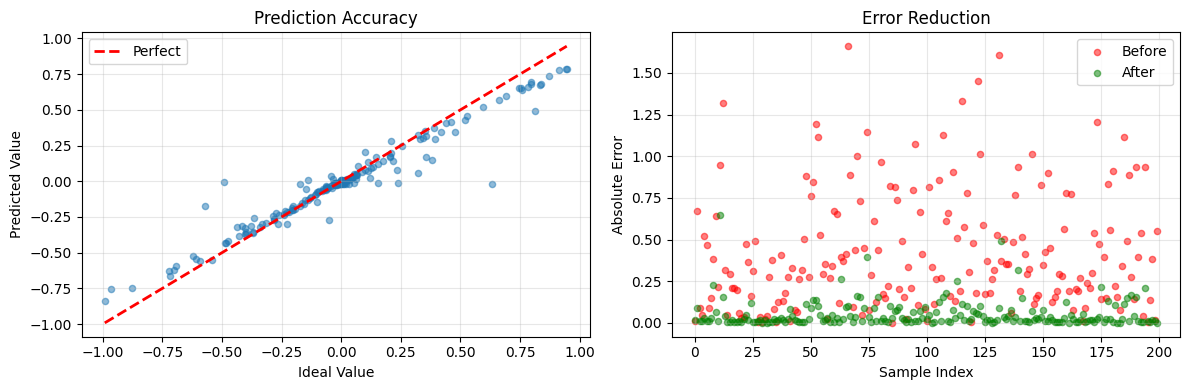

In [ ]:
if __name__ == '__main__':
    main()

# 3. Benchmarking

In [ ]:
import numpy as np
from qiskit.circuit.library import efficient_su2

def create_variational_circuit(num_qubits, depth, entanglement):
    ansatz = efficient_su2(
        num_qubits=num_qubits,
        reps=depth,
        entanglement=entanglement,
        insert_barriers=False
    )

    params = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
    circuit = ansatz.assign_parameters(params)

    return circuit.decompose()


In [ ]:
from qiskit import QuantumCircuit

def create_qaoa_circuit(num_qubits, depth):
    qc = QuantumCircuit(num_qubits)

    for _ in range(depth):
        # Cost layer
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)
            qc.rz(np.random.uniform(0, 2*np.pi), i + 1)
            qc.cx(i, i + 1)

        # Mixer layer
        for q in range(num_qubits):
            qc.rx(np.random.uniform(0, 2*np.pi), q)

    return qc


In [ ]:
def create_random_circuit(num_qubits, depth):
    qc = QuantumCircuit(num_qubits)

    for _ in range(depth):
        for q in range(num_qubits):
            gate = np.random.choice(["rx", "ry", "rz"])
            angle = np.random.uniform(0, 2*np.pi)
            getattr(qc, gate)(angle, q)

        for q in range(num_qubits - 1):
            if np.random.rand() < 0.5:
                qc.cx(q, q + 1)

    return qc


In [ ]:
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
    amplitude_damping_error,
    ReadoutError
)

def create_noise_model(num_qubits, noise_type, error_rate):
    noise_model = NoiseModel()

    if noise_type == "depolarizing":
        error_1q = depolarizing_error(error_rate, 1)
        error_2q = depolarizing_error(min(10 * error_rate, 0.3), 2)

        noise_model.add_all_qubit_quantum_error(error_1q, ["ry", "rz", "rx"])
        noise_model.add_all_qubit_quantum_error(error_2q, ["cx"])

    elif noise_type == "amplitude_damping":
        error_1q = amplitude_damping_error(error_rate)
        noise_model.add_all_qubit_quantum_error(error_1q, ["ry", "rz", "rx"])

    elif noise_type == "readout":
        ro_error = ReadoutError([
            [1 - error_rate, error_rate],
            [error_rate, 1 - error_rate]
        ])
        for q in range(num_qubits):
            noise_model.add_readout_error(ro_error, [q])

    return noise_model


In [ ]:
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp

def simulate_noisy_expectation(circuit, noise_model):
    simulator = AerSimulator(
        noise_model=noise_model,
        method="density_matrix"
    )

    qc = circuit.copy()
    qc.save_density_matrix()

    result = simulator.run(qc).result()
    rho = result.data()["density_matrix"]

    observable = SparsePauliOp("Z" * circuit.num_qubits)

    return float(rho.expectation_value(observable).real)


In [ ]:
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp

def simulate_ideal_expectation(circuit):
    simulator = AerSimulator(method="statevector")

    qc = circuit.copy()
    qc.save_statevector()

    result = simulator.run(qc).result()
    psi = result.data()["statevector"]

    observable = SparsePauliOp("Z" * circuit.num_qubits)

    return float(psi.expectation_value(observable).real)


In [ ]:
import pandas as pd

records = []

num_qubits_list = [4, 6, 8, 10]
depths = [2, 4, 6, 8, 10]
depth_multiplayers = [1, 2, 3]
entanglements = ["linear", "full", "pairwise"]
noise_types = ["depolarizing", "amplitude_damping","readout"]
error_rates = [0.001, 0.005, 0.01, 0.02, 0.05]
observables = ["Z", "ZZ", "XX"]

circuit_types = ["variational", "qaoa", "random"]


for num_qubits in num_qubits_list:
    for depth in depths:
        for ent in entanglements:
            for noise_type in noise_types:
                for error_rate in error_rates:

                    # Choose circuit type
                    circuit_type = np.random.choice(
                        ["variational", "qaoa", "random"]
                    )

                    if circuit_type == "variational":
                        circuit = create_variational_circuit(
                            num_qubits, depth, ent
                        )
                    elif circuit_type == "qaoa":
                        circuit = create_qaoa_circuit(
                            num_qubits, depth
                        )
                    else:
                        circuit = create_random_circuit(
                            num_qubits, depth
                        )
                    x_ideal = simulate_ideal_expectation(circuit)


                    noise_model = create_noise_model(
                        num_qubits, noise_type, error_rate
                    )


                    x_noisy = simulate_noisy_expectation(
                        circuit, noise_model
                    )

                    records.append({
                        "num_qubits": num_qubits,
                        "depth": depth,
                        "depth_multiplier": 1,
                        "entanglement": ent,
                        "noise_type": noise_type,
                        "error_rate": error_rate,
                        "observable_name": "Z" * num_qubits,
                        "x_noisy": x_noisy,
                        "x_ideal":x_ideal
                    })

benchmark_df = pd.DataFrame(records)


In [ ]:
benchmark_df.to_csv("benchmarking_dataset.csv",index = False)

In [ ]:
import torch

checkpoint = torch.load("qem_model.pth", map_location="cpu",weights_only=False)

model_state = checkpoint["model_state_dict"]
model_config = checkpoint["model_config"]

scaler_x = checkpoint["scalers"]["scaler_x"]
scaler_y = checkpoint["scalers"]["scaler_y"]

encoder_noise = checkpoint["encoders"]["encoder_noise"]
encoder_ent = checkpoint["encoders"]["encoder_ent"]


In [ ]:
device = "cpu"

model = NoiseAwareQEMModel(
    input_dim=model_config["input_dim"],
    latent_dim=model_config["latent_dim"]
)

model.load_state_dict(model_state)
model.to(device)
model.eval()


NoiseAwareQEMModel(
  (noise_descriptor): NoiseDescriptorNetwork(
    (network): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (mitigation_network): ConditionalMitigationNetwork(
    (network): Sequential(
      (0): Linear(in_features=22, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affin

In [ ]:
from torch.utils.data import DataLoader

test_dataset = QEMDataset(
    csv_file="benchmarking_dataset.csv",
    scaler_x=scaler_x,
    scaler_y=scaler_y,
    encoder_noise=encoder_noise,
    encoder_ent=encoder_ent
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False
)


In [ ]:
import numpy as np

all_preds_scaled = []

with torch.no_grad():
    for features, _ in test_loader:
        features = features.to(device)

        preds_scaled, z = model(features)
        all_preds_scaled.append(preds_scaled.cpu().numpy())

# Concatenate
preds_scaled = np.vstack(all_preds_scaled)

# Inverse-scale to physical values
x_model = scaler_y.inverse_transform(preds_scaled).flatten()


In [ ]:
test_dataset.df["x_model"] = x_model


In [ ]:
df = test_dataset.df

df["abs_error_noisy"] = abs(df["x_noisy"] - df["x_ideal"])
df["abs_error_model"] = abs(df["x_model"] - df["x_ideal"])

print("No mitigation MAE :", df["abs_error_noisy"].mean())
print("Model mitigation MAE :", df["abs_error_model"].mean())

print("Improvement ratio R =",
      df["abs_error_noisy"].mean() / df["abs_error_model"].mean())


No mitigation MAE : 0.026271801680791664
Model mitigation MAE : 0.0344550777786541
Improvement ratio R = 0.7624943368163805


In [ ]:
depth_grouped = df.groupby("depth").agg({
    "abs_error_noisy": "mean",
    "abs_error_model": "mean"
})

depth_grouped["R"] = (
    depth_grouped["abs_error_noisy"] /
    depth_grouped["abs_error_model"]
)

depth_grouped


,abs_error_noisy,abs_error_model,R
depth,,,
2,0.020358,0.029981,0.679007
4,0.021604,0.031229,0.691786
6,0.026779,0.033963,0.788462
8,0.027088,0.032546,0.832287
10,0.035531,0.044556,0.797457


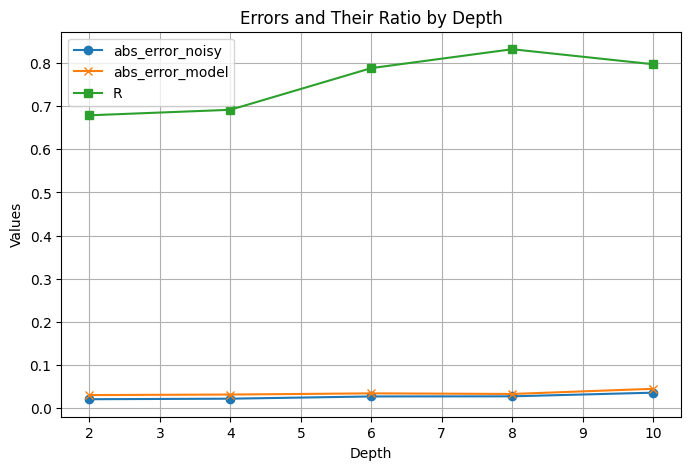

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(depth_grouped.index, depth_grouped["abs_error_noisy"], marker='o', label="abs_error_noisy")
plt.plot(depth_grouped.index, depth_grouped["abs_error_model"], marker='x', label="abs_error_model")
plt.plot(depth_grouped.index, depth_grouped["R"], marker='s', label="R")
plt.xlabel("Depth")
plt.ylabel("Values")
plt.title("Errors and Their Ratio by Depth")
plt.legend()
plt.grid(True)
plt.show()
